# Audio Classification Using Deep Learning

## 1. Problem Statement 

### Design, Build and Test  Deep Learning Model to classify cat and dog sound from the wav files 

### Importing a Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# audio plot 
from scipy.io import wavfile as wav
import IPython.display as ipd

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import Callback,EarlyStopping
from tensorflow.keras.layers import Activation, Flatten, Dense, Dropout

In [2]:
import warnings 
warnings.filterwarnings("ignore")

## 2. Data Preparation

In [3]:
path__='../Task 1/archive/cats_dogs'   ## Paths of data
p_train = '../Task 1/archive/cats_dogs/train'
p_test = '../Task 1/archive/cats_dogs/test'

In [4]:
data_train = list(glob.glob(p_train+'/**/*.wav')) # Glob module will list all the files from given path with extension .wav
data_test = list(glob.glob(p_test+'/**/*.wav'))

In [5]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], data_train)) #It Create list of labels corresponds to the parent directory names of the files.
file_path = pd.Series(data_train, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
df = pd.concat([file_path, labels], axis=1) # DataFrame created
df = df.sample(frac=1).reset_index(drop=True) # This line shuffles the rows of the DataFrame df randomly using the sample() method with frac=1 (which means to return all rows) and then resets the index of the DataFrame to a sequential integer index starting from 0 using the reset_index() method.
df.head() 

,File_Path,Labels
0,../Task 1/archive/cats_dogs/train\dog\dog_bark...,dog
1,../Task 1/archive/cats_dogs/train\dog\dog_bark...,dog
2,../Task 1/archive/cats_dogs/train\cat\cat_98.wav,cat
3,../Task 1/archive/cats_dogs/train\cat\cat_80.wav,cat
4,../Task 1/archive/cats_dogs/train\cat\cat_60.wav,cat


## 2.Data Preprocessing/EDA

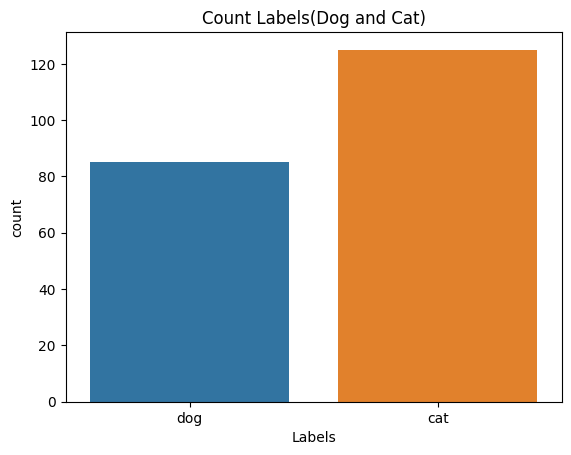

cat    125
dog     85
Name: Labels, dtype: int64

In [6]:
sns.countplot(x='Labels', data=df)
plt.title('Count Labels(Dog and Cat)')
plt.show()
df['Labels'].value_counts()

### Here we plot acount plot of Labels and we observe that there are 125 cat audio files and 85 dog audio files

In [7]:
# here we take one sample sound file 
filename="archive/dog_barking_0.wav"

In [8]:
import IPython.display as ipd
# Create an audio object.
# When this object is returned by an input cell or passed to the display function, it will result in Audio controls 
# being displayed in the frontend (only works in the notebook).

In [9]:
import librosa  
import librosa.display

# Librosa is a Python library for analyzing and processing audio signals. It provides tools for loading audio files in various formats, such as WAV and MP3, and for converting them to numerical data that can be processed with Python

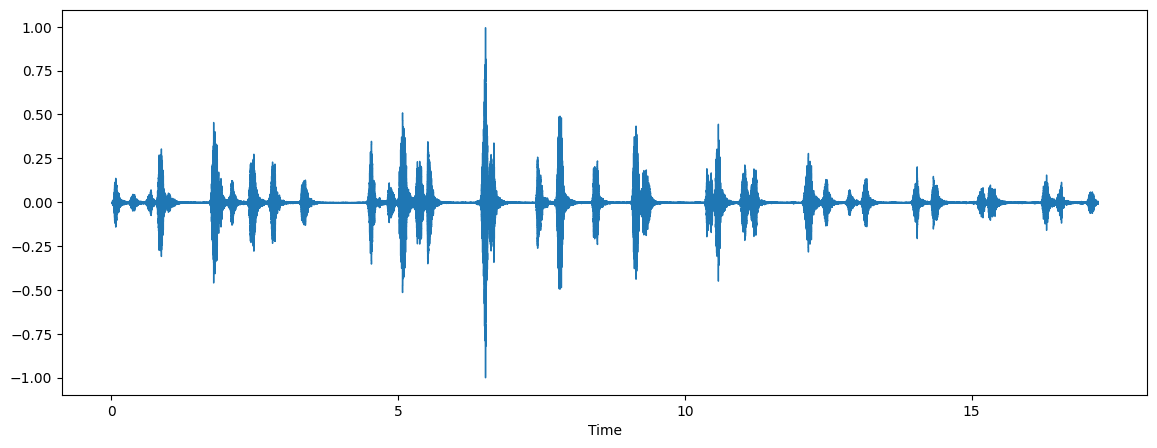

In [10]:
### Dog Sound
plt.figure(figsize=(14,5))
data,sample_rate=librosa.load(filename)
librosa.display.waveshow(data,sr=sample_rate) # using wavwshow we can find the sample rate
ipd.Audio(filename) ## This reads the sample rate

### This graph shows the signals of Dog barking after 5 sec it signals that it was a dog sound

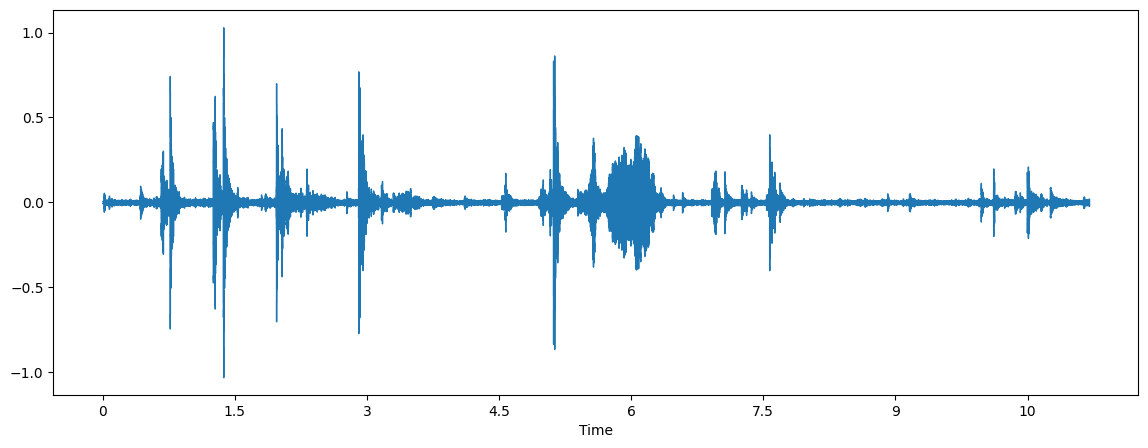

In [11]:
### Cat sound
filename="archive/cat_1.wav"
plt.figure(figsize=(14,5))
data,sample_rate=librosa.load(filename)
librosa.display.waveshow(data,sr=sample_rate)
ipd.Audio(filename)

### This graph shows the signal of cat sound at time of 6 sec

In [12]:
sample_rate 
# In audio production a sample rate defines how ,many times per second a sound is sampled the standard sample rate used for audio CDs is 44.1 kilohertz(44100 hertz) That means each second of song on a CD contains 44,100 individual samples

#here librosa library will try to convert a audio in 22050 hertz

22050

### Here we reading aaudio in approximately 22 kilohertz

In [13]:
from scipy.io import wavfile as wav 
wave_sample_rate, wave_audio=wav.read(filename)

# Using scipy library  also we can check the wave_sample rate and wave_audio

In [14]:
wave_sample_rate

16000

### Using scipy library everytime we get different sample rates 

In [15]:
wave_audio  # Using Scipy

array([ 124,  107,    7, ..., -545, -494, -529], dtype=int16)

In [16]:
data # Using Librosa

array([ 0.00369679,  0.00401708,  0.00156103, ..., -0.01461057,
       -0.0178325 , -0.01211241], dtype=float32)

In [20]:
data.shape

(246960,)

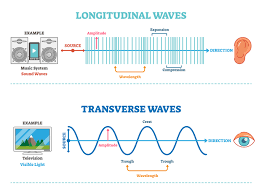

### The waves of sound represented in integer or float format this array gives waves of sound using scipy and librosa library

### Using Librosa Library we get normalize(-1 to +1) format of wave signals values so that regular pattern is observed from all the audios  
### Librosa library tries to convert audio in one signal i.e one diamentional signal or mono channel
### Using Librosa we can see the sample rate of audio file and it will convert it into 22050 hertz and using scipy we get different sample rates for each audio

## Extract Features

* Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples. The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification. *

#### MFCC will take the signals and create a independent features that will represent the particular audio data
#### It will convert a audio into some kind of features using frequency and time characteristics of sound that will help us to do classification


In [17]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') ## it will give sample rate
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40) # all audio signals converted to array
    mfccs_processed = np.mean(mfccs.T,axis=0)
    return mfccs_processed

In [18]:
import numpy as np
features = []
for index, row in df.iterrows(): #iterate over all the rows in dataframe
    file_name = str(row['File_Path'])
    class_label = row["Labels"]
    data_ = extract_features(file_name)
    features.append([data_, class_label])

In [19]:
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
featuresdf.head() # created a DataFrame with array or feature and label

,feature,class_label
0,"[-394.7676, 134.88695, -1.1933523, 32.698868, ...",cat
1,"[-329.59042, 159.63338, -43.740906, -25.752813...",dog
2,"[-309.5973, 167.24559, -12.499739, -32.55835, ...",dog
3,"[-273.3715, 88.16707, -50.097332, 44.589333, -...",cat
4,"[-442.7546, 153.41211, -11.273686, 51.376614, ...",cat


## 3. Model Building

In [20]:
x = np.array(featuresdf["feature"].tolist())
y = np.array(featuresdf["class_label"].tolist())

In [21]:
x.shape

(210, 40)

In [22]:
y.shape

(210,)

In [23]:
### Label Encoding

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

labelencoder=LabelEncoder() # The LabelEncoder is a utility class that can be used to transform categorical labels into numerical labels.
y=to_categorical(labelencoder.fit_transform(y)) # it converts categorical variable into numerical format using one hot encoding

In [24]:
y

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.

### Train_Test_split

In [25]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

### Model Training

In [26]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [28]:
### No of classes
num_labels=y.shape[1]

In [29]:
model=Sequential() #create neural networks in a sequential manner
###first layer
model.add(Dense(100,input_shape=(40,))) # x have 400 features so we take shape 40
model.add(Activation('relu')) # Relu activation is the best fit for hidden layer
model.add(Dropout(0.5)) # This is a regularization layer
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('sigmoid')) # sigmoid function is used for binary classification

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

In [31]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [32]:
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

In [33]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[earlystop], epochs=100)
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.

Epoch 1/100
6/6 [==============================] - 1s 29ms/step - loss: 26.1697 - accuracy: 0.4583 - val_loss: 15.9404 - val_accuracy: 0.5952
Epoch 2/100
6/6 [==============================] - 0s 7ms/step - loss: 24.3968 - accuracy: 0.5179 - val_loss: 1.1785 - val_accuracy: 0.7143
Epoch 3/100
6/6 [==============================] - 0s 7ms/step - loss: 15.5402 - accuracy: 0.5417 - val_loss: 3.5357 - val_accuracy: 0.5714
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 14.6069 - accuracy: 0.5774 - val_loss: 2.6019 - val_accuracy: 0.6905
Epoch 5/100
6/6 [==============================] - 0s 7ms/step - loss: 12.8460 - accuracy: 0.5952 - val_loss: 0.8479 - val_accuracy: 0.7857
Epoch 6/100
6/6 [==============================] - 0s 7ms/step - loss: 10.5715 - accuracy: 0.5536 - val_loss: 0.8394 - val_accuracy: 0.8571
Epoch 7/100
6/6 [==============================] - 0s 7ms/step - loss: 9.3056 - accuracy: 0.6488 - val_loss: 0.7683 - val_accuracy: 0.8333
Epoch 8/100
6/6 [==

### Model Evaluation

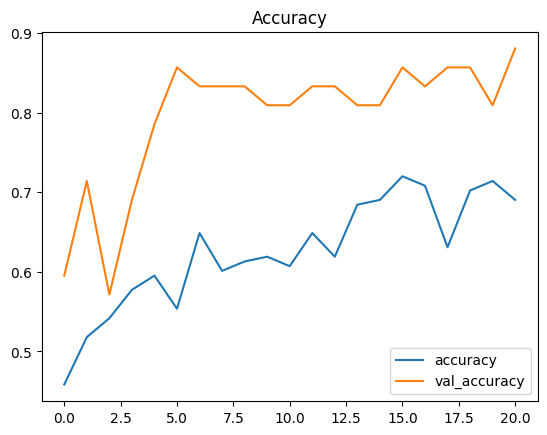

In [34]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

### Here we get more val_accuracy 

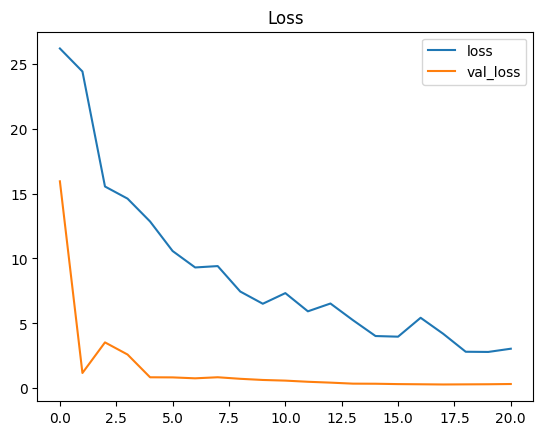

In [35]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

### Here we observe that val_loss decreases 

In [36]:
test_accuracy=model.evaluate(x_test,y_test,verbose=0)
print("Test Accuracy")
print(test_accuracy[1])
print()
train_accuracy=model.evaluate(x_train,y_train,verbose=0)
print("Train Accuracy")
print(train_accuracy[1])

Test Accuracy
0.8809523582458496

Train Accuracy
0.851190447807312


### We get Test Accuracy as 88% so we can say that our model predicts 88% accurate results

## 4. Testing Audio

In [41]:
def prediction_(path_sound):
    data_sound = extract_features(path_sound)
    x = np.array(data_sound)
    x = x.reshape(1,40)
    pred_ = model.predict(x)
    pred_ = np.argmax(pred_,axis=1)
    pred_class = labelencoder.inverse_transform(pred_)
    print("The predicted class is:\033[01m ", pred_class[0],'\033[0m \n')

In [42]:
path_sound = '../Task 1/archive/cats_dogs/test/cats/cat_126.wav'
prediction_(path_sound)
ipd.Audio(path_sound)

1/1 [==============================] - 0s 14ms/step
The predicted class is:  cat  

